In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/data/mHealth_subject1.log'
if not os.path.exists(file_path):
    print(f"오류: 파일 '{file_path}'를 찾을 수 없습니다. 파일을 현재 디렉터리에 놓아주세요.")
else:
    print(f"파일 '{file_path}'를 읽어들이는 중...")

    # 데이터셋 열 이름 정의
    column_names = [
        'chest_accel_x', 'chest_accel_y', 'chest_accel_z',
        'ecg_lead1', 'ecg_lead2',
        'ankle_accel_x', 'ankle_accel_y', 'ankle_accel_z',
        'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
        'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
        'arm_accel_x', 'arm_accel_y', 'arm_accel_z',
        'arm_gyro_x', 'arm_gyro_y', 'arm_gyro_z',
        'arm_mag_x', 'arm_mag_y', 'arm_mag_z',
        'activity_label'
    ]

    # 탭으로 구분된 파일 읽기
    df = pd.read_csv(file_path, sep='\s+', header=None, names=column_names)


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3838461967.py:21: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, names=column_names)


파일 '/content/drive/MyDrive/Colab Notebooks/data/mHealth_subject1.log'를 읽어들이는 중...


In [4]:
    print("\n[데이터 정보]")
    df.info()



[데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161280 entries, 0 to 161279
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   chest_accel_x   161280 non-null  float64
 1   chest_accel_y   161280 non-null  float64
 2   chest_accel_z   161280 non-null  float64
 3   ecg_lead1       161280 non-null  float64
 4   ecg_lead2       161280 non-null  float64
 5   ankle_accel_x   161280 non-null  float64
 6   ankle_accel_y   161280 non-null  float64
 7   ankle_accel_z   161280 non-null  float64
 8   ankle_gyro_x    161280 non-null  float64
 9   ankle_gyro_y    161280 non-null  float64
 10  ankle_gyro_z    161280 non-null  float64
 11  ankle_mag_x     161280 non-null  float64
 12  ankle_mag_y     161280 non-null  float64
 13  ankle_mag_z     161280 non-null  float64
 14  arm_accel_x     161280 non-null  float64
 15  arm_accel_y     161280 non-null  float64
 16  arm_accel_z     161280 non-null  float64
 17  

In [6]:
    # 결측치 확인
    print("\n[결측치 수]")
    print(df.isnull().sum())



[결측치 수]
chest_accel_x     0
chest_accel_y     0
chest_accel_z     0
ecg_lead1         0
ecg_lead2         0
ankle_accel_x     0
ankle_accel_y     0
ankle_accel_z     0
ankle_gyro_x      0
ankle_gyro_y      0
ankle_gyro_z      0
ankle_mag_x       0
ankle_mag_y       0
ankle_mag_z       0
arm_accel_x       0
arm_accel_y       0
arm_accel_z       0
arm_gyro_x        0
arm_gyro_y        0
arm_gyro_z        0
arm_mag_x         0
arm_mag_y         0
arm_mag_z         0
activity_label    0
dtype: int64


In [7]:
    # 활동 레이블 분포 확인
    print("\n[활동 레이블 분포]")
    print(df['activity_label'].value_counts().sort_index())



[활동 레이블 분포]
activity_label
0     126106
1       3072
2       3072
3       3072
4       3072
5       3072
6       3072
7       3072
8       3379
9       3072
10      3072
11      3072
12      1075
Name: count, dtype: int64


In [8]:
    # 데이터 및 레이블 분리
    X = df.drop('activity_label', axis=1)
    y = df['activity_label']


In [9]:
    # ==============================================================================
    # 3. 데이터 스케일링
    # ==============================================================================
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("\n[데이터 스케일링 완료]")



[데이터 스케일링 완료]


In [10]:
    # ==============================================================================
    # 4. 레이블 원-핫 인코딩
    # ==============================================================================
    encoder = OneHotEncoder(sparse_output=False)
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    num_classes = y_encoded.shape[1]
    print(f"\n[레이블 원-핫 인코딩 완료], 클래스 수: {num_classes}")



[레이블 원-핫 인코딩 완료], 클래스 수: 13


In [11]:
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [12]:
    # ==============================================================================
    # 5. 모델 구축 (CNN-Transformer 하이브리드)
    # ==============================================================================
    def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
        # Layer Normalization 1
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        # Multi-Head Attention
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
        # Dropout
        x = layers.Dropout(dropout)(x)
        # Residual Connection 1
        res = x + inputs

        # Layer Normalization 2
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        # Feed Forward
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        # Residual Connection 2
        return x + res


In [13]:
    input_shape = (X_reshaped.shape[1], 1)

    inputs = tf.keras.Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    # Transformer 인코더 블록
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

    # 전역 풀링 및 최종 분류
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)


In [14]:
    # 모델 컴파일
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 모델 요약 출력
    model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 23, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 23, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 23, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 11, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 11, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 11, 64)    │        128 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 11, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 64)    │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 11, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 11, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 11, 64)    │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 11, 64)    │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 11, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 11, 64)    │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 179,853 (702.55 KB)

 Trainable params: 179,853 (702.55 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
    # ==============================================================================
    # 6. 모델 학습
    # ==============================================================================
    X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

    print("\n[모델 학습 시작]")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,  # 에포크 수 조정 가능
        batch_size=256, # 배치 크기 조정 가능
        verbose=1
    )



[모델 학습 시작]
Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 136s 263ms/step - accuracy: 0.8464 - loss: 0.4371 - val_accuracy: 0.8598 - val_loss: 0.4531
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 140s 260ms/step - accuracy: 0.8634 - loss: 0.3652 - val_accuracy: 0.8517 - val_loss: 0.4605
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.8737 - loss: 0.3317 - val_accuracy: 0.8854 - val_loss: 0.3487
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 146s 267ms/step - accuracy: 0.8817 - loss: 0.3078 - val_accuracy: 0.8859 - val_loss: 0.3619
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 142s 268ms/step - accuracy: 0.8853 - loss: 0.2989 - val_accuracy: 0.9027 - val_loss: 0.3040
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 139s 261ms/step - accuracy: 0.8937 - loss: 0.2781 - val_accuracy: 0.9010 - val_loss: 0.2848
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 141s 260ms/step - accuracy: 0.8949 - loss: 0.2694 - val_accuracy: 0.8942 - val_loss: 0.3057
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accura

In [17]:
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print("\n[분류 보고서]")
    print(classification_report(y_true, y_pred))

    print("\n[혼동 행렬]")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step

[분류 보고서]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     25260
           1       0.71      1.00      0.83       589
           2       0.69      1.00      0.82       617
           3       0.76      1.00      0.86       579
           4       0.71      0.99      0.83       638
           5       0.66      0.76      0.71       621
           6       0.77      1.00      0.87       592
           7       0.76      1.00      0.86       596
           8       0.68      0.95      0.79       682
           9       0.68      0.99      0.81       635
          10       0.69      0.93      0.79       596
          11       0.84      0.88      0.86       619
          12       0.59      0.71      0.64       232

    accuracy                           0.91     32256
   macro avg       0.73      0.93      0.82     32256
weighted avg       0.93      0.91      0.91     32256


[혼동 행렬]
[[22738   237  

In [18]:
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)


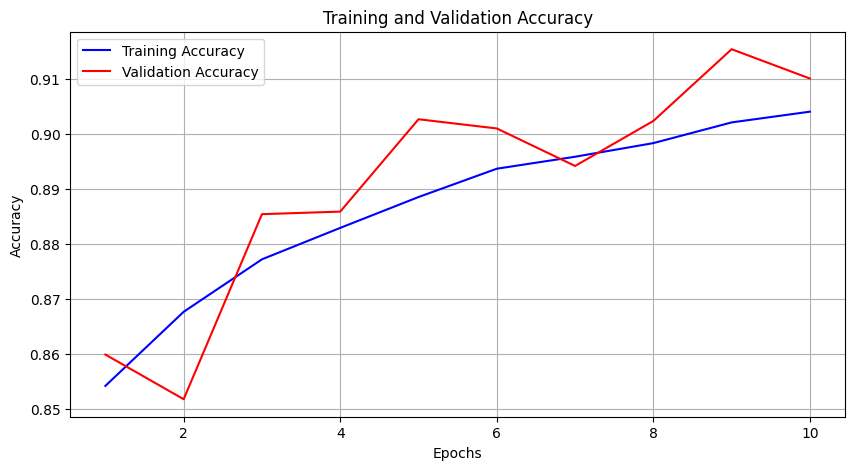

In [19]:
    # Accuracy graph
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

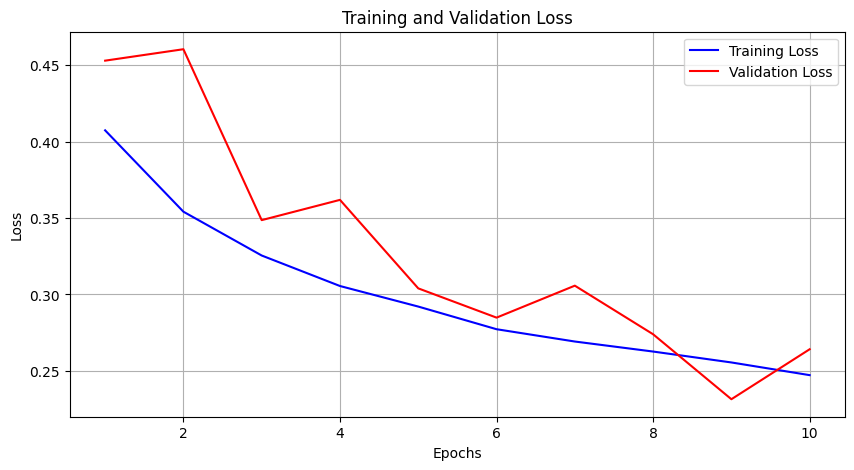

In [20]:
    # Loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()